# 목표
> LangGraph 를 사용하여 간단한 RAG 파이프라인을 구현한다(Pseudo Code)

1. Query 를 통한 Retrieve
2. GPT 와 Claude 를 통한 답변 생성 및 Relevance 검사
3. 결과 종합
4. 결과 품질을 확인하여 종료하거나 쿼리를 재작성

## Environment

In [1]:
from langchain_core.documents import Document
from typing import TypedDict, Annotated, Sequence
import operator

#### `Document Class`
> Langchain 라이브러리에서 텍스트와 그에 관련된 메타데이터를 저장하는 데 사용됩니다.
- page_content와 metadata 속성을 가지며, 이들은 각각 문서의 **텍스트 내용**과 그에 대한 **메타데이터**를 저장합니다.
- 아래 예시 코드는 "This is a sample document."라는 텍스트와 함께 저자와 생성 날짜에 대한 메타데이터를 포함하는 Document 객체를 생성합니다.

``` python
doc = Document(page_content="This is a sample document.", metadata={"author": "John Doe", "created": "2024-07-01"})
```


#### `typing`
> typing 모듈은 파이썬에서 타입 힌트를 제공하는 모듈로, 코드의 가독성을 높이고 타입 안전성을 확보하는 데 사용됩니다.

- `TypedDict`:
    - TypedDict는 딕셔너리의 각 키와 값의 타입을 명시적으로 정의할 수 있게 해주는 클래스입니다.
    - 주로 딕셔너리를 사용하는 데이터 구조에서 특정 키에 대한 값의 타입을 고정할 때 유용합니다.

- `Annotated`:
    - Annotated는 타입 힌트에 추가 메타데이터를 제공할 수 있게 해줍니다.

- `Sequence`:
    - Sequence는 리스트, 튜플과 같은 시퀀스 타입을 나타내는 타입 힌트입니다.

#### `operator`:
> operator 모듈은 파이썬의 내장 연산자를 함수로 제공하는 모듈로, 주로 함수형 프로그래밍 스타일이나 연산을 추상화하는 데 사용됩니다.
- operator.add(a, b): a + b와 동일합니다.
``` python
doc1 = Document("This is the first document.")
doc2 = Document("This is the second document.")
doc3 = Document("This is the third document.")

graph_state: GraphState = {
    "context": [doc1, doc2, doc3]
}

combined_content = reduce(operator.add, [doc.content for doc in graph_state["context"]])
print("Combined Content:", combined_content)

>>>
Combined Content: This is the first document.This is the second document.This is the third document.
```

---

## Define State 

In [2]:
class PseudoState(TypedDict):
    context: Annotated[Sequence[Document], operator.add]
    answer: Annotated[Sequence[Document], operator.add]
    question: str
    query: str
    score: str

## Define Nodes

In [5]:
def retrieve(state: PseudoState) -> PseudoState:
    # retrieve: 검색
    doc1 = Document("This is the first document.")
    doc2 = Document("This is the second document.")
    doc3 = Document("This is the third document.")

    return PseudoState(context=[doc1, doc2, doc3])

def rewrite_query(state: PseudoState) -> PseudoState:
    # Query transformation: 쿼리 재작성
    query = '재작성된 쿼리'
    return PseudoState(query=query)

def llm_gpt_generation(state: PseudoState) -> PseudoState:
    # LLM 실행
    answer = "GPT 의 생성된 답변"
    return PseudoState(answer=answer)

def llm_claude_generation(state: PseudoState) -> PseudoState:
    # LLM 실행
    answer = "Claude 의 생성된 답변"
    return PseudoState(answer=answer)

def relevance_check(state: PseudoState) -> PseudoState:
    return PseudoState()

def sum_up(state: PseudoState) -> PseudoState:
    return PseudoState()

def valid_query(state: PseudoState) -> PseudoState:
    return PseudoState()

def handle_error(state: PseudoState) -> PseudoState:
    return PseudoState()

def decision(state: PseudoState) -> PseudoState:
    return PseudoState()

## Define Graph

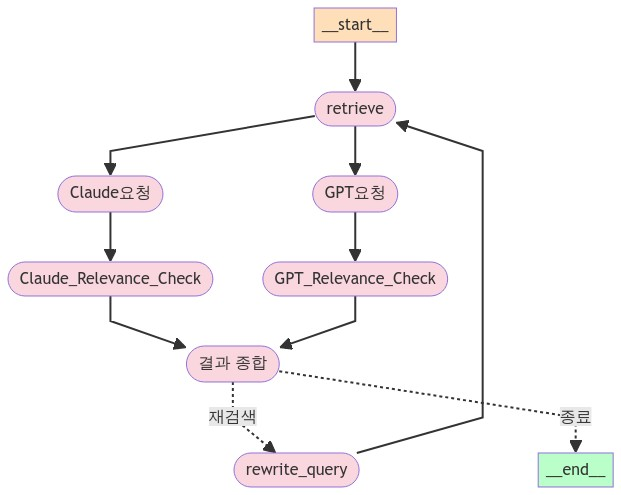

In [20]:
from IPython.display import Image, display
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# Initialize Graph
workflow = StateGraph(PseudoState)

# Add Nodes
workflow.add_node('retrieve', retrieve)
workflow.add_node('rewrite_query', rewrite_query)
workflow.add_node('GPT요청', llm_gpt_generation)
workflow.add_node('Claude요청', llm_claude_generation)
workflow.add_node('GPT_Relevance_Check', relevance_check)
workflow.add_node('Claude_Relevance_Check', relevance_check)
workflow.add_node('결과 종합', sum_up)


# Connect Nodes
workflow.add_edge('retrieve', 'GPT요청')
workflow.add_edge('retrieve', 'Claude요청')
workflow.add_edge('rewrite_query', 'retrieve')
workflow.add_edge('GPT요청', 'GPT_Relevance_Check')
workflow.add_edge('GPT_Relevance_Check', '결과 종합')
workflow.add_edge('Claude요청', 'Claude_Relevance_Check')
workflow.add_edge('Claude_Relevance_Check', '결과 종합')


# Add Conditional Edge
workflow.add_conditional_edges(
    "결과 종합", # 결과 종합에서 반환된 값을 decision 함수에 전달
    decision,
    {
        "재검색": 'rewrite_query', # 답변이 이상하다면 쿼리를 재검색
        "종료": END # 답변이 잘 생성되었다면 종료
    }
)

# 시작점 설정
workflow.set_entry_point('retrieve')

app = workflow.compile()

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )
except:
    pass


---

실제 RAG 를 수행하는 경우 아래 Config 를 설정하자.

<div style="text-align: center;">
    <img src="./img/graph_config.png" alt="Indexing" style="width: 70%;">
</div>

#### Reference
- https://www.youtube.com/watch?v=4JdzuB702wI&t=123s
- https://github.com/teddylee777/langchain-kr/tree/main/17-LangGraph